In [5]:
import regex as re

from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
# fern_species = pd.read_excel("Species list.xlsx")


## Extract PDF

In [214]:
from tqdm.auto import tqdm

conditional_newline = lambda sp: '\s*\n?'.join(sp.split(' ')).replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')
sp_descriptions = pd.DataFrame()
for fam in tqdm(fern_species.Family.unique()):
    text = ""
    with open(f"descriptions/{fam}.pdf", "rb") as pdf_file:
        read_pdf = PdfReader(pdf_file)
        for i, page in enumerate(read_pdf.pages):
            if i < 5:
                continue
            tx = page.extract_text()
            if tx.split("\n")[0].startswith('References'):
                # print(f"Breaking at page {i}")
                break
            text += page.extract_text()
    text = re.sub(r'[^\S\r\n]+', ' ', text)

    fam_species = fern_species[fern_species.Family.eq(fam)].Species.unique()
    sp_dict = {}
    for i, species in enumerate(fam_species):
        species = species
        if (cnt := len(re.findall(conditional_newline(species), text))) == 0:
            print(f"{fam} | {species} wrongly appearing (count: {cnt})")
            foo
        # start = text.find(species)
        # start is the first character of the species name assuming to find it in the text
        # with potentially some '\n' characters in between
        start = re.search(conditional_newline(species), text).start()
        end = [re.search(conditional_newline(sp), text).start() for sp in fam_species]
        end = min([e for e in end if e and e > start] + [len(text)])
        name_sp = species.split(')')[0] + ')'
        if name_sp not in sp_dict.keys():
            sp_dict[name_sp] = text[start:end]
        else:
            sp_dict[name_sp] += '\n' + text[start:end]

    sp_descriptions = pd.concat([sp_descriptions, pd.DataFrame(sp_dict.items(), columns=['Species', 'Description']).assign(Family=fam)], ignore_index=True)


def desc_to_sections(desc):
    """
    Split the description into sections:
    "Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record ", "Recognition ", "Cytology", "Hybridisation", "Notes "
    not all the sections will be present in all descriptions, if present, they start with the section name followed by a colon, up to the next named section or the end of the description
    """
    sections = ["Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record", "Recognition", "Cytology", "Hybridisation", "Notes"]
    section_dict = {}
    for i, section in enumerate(sections):
        if i == len(sections) - 1:
            section_dict[section] = desc
        else:
            start = re.search(fr"{section}s?:", desc)
            start = start.end() if start else -1
            if start == -1:
                continue
            end = re.search(fr"{sections[i+1]}s?:", desc)
            end = end.start() if end else -1

            this_desc = desc[start:end].strip()

            section_dict[section] = re.sub(r'\n+', ' ', this_desc.strip())
    return pd.Series(section_dict)

extra = sp_descriptions.Description.apply(desc_to_sections)  
sp_descriptions = pd.concat([sp_descriptions, extra], axis=1).drop(columns='Description')

NameError: name 'fern_species' is not defined

In [50]:
sp_descriptions.to_excel("fern_descriptions.xlsx", index=False)

# Extract features

In [215]:
sp_descriptions = pd.read_excel("fern_descriptions.xlsx").set_index('Species')

In [216]:
extra_features_df = pd.read_excel("../Words before and after traits_v2.xlsx", sheet_name="FernPrecedingWords")
extra_features_df = extra_features_df.drop(columns=[c for c in extra_features_df.columns if 'Unnamed' in c])
extra_features_df = extra_features_df[
    :extra_features_df[extra_features_df.Rhizome.str.startswith('Sentences that talk a', na=False)].index[0]
    ].map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [137]:
extra_features

{'Rhizome': ['Rhizome', 'Rhizomes', 'Stem', 'Stems'],
 'Frond': ['Fronds', 'Frond', 'Leaf', 'Leaves'],
 'FertileFronds': ['Fertile'],
 'SterileFronds': ['Sterile'],
 'Stipe': ['Stipe', 'Stipes'],
 'Rachis': ['Rachis', 'Rachises'],
 'Laminae': ['Laminae', 'Lamina'],
 'Sori': ['Sori', 'Sorus'],
 'Spores': ['Spores', 'Spore'],
 'Sporangia': ['Sporangia', 'Sporangium', 'Synangia', 'Synangium'],
 'Habitat': ['Aquatic',
  'Epiphytic',
  'Creeping',
  'Climbing',
  'Climber',
  'Climbers',
  'Creeper',
  'Creepers',
  'Terrestrial',
  'Lithophytic'],
 'Indusia': ['Indusia', 'Indusium'],
 'Habit': ['Creeping, Terrestrial, Both'],
 'Biostatus': ['Indigenous',
  'Native',
  'Exotic',
  'Endemic',
  'Non-Endemic',
  'Casual',
  'Fully Naturalized']}

In [5]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [234]:
feat = 'Rhizomes short-to long-creeping, up to 100mm-long (in herbarium specimens), 0.8-1.7mm in diameter, with stipes arising 1-9mm apart; bearing scales'
candidate_feat = {}
for key, values in extra_features.items():
    if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
        continue
    matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
    if any(matched_word):
        candidate_feat[key] = matched_word[0]
if any(candidate_feat):
# feat is the first appearing candidate_feat
    key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
    matched_word = candidate_feat[key]
key, matched_word

('Rhizome', <re.Match object; span=(0, 8), match='rhizomes'>)

In [327]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence

		candidate_feat = {}
		for key, values in extra_features.items():
			if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
				continue
			matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
			if any(matched_word):
				candidate_feat[key] = matched_word[0]
		if not any(candidate_feat):
			continue
		key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
		matched_word = candidate_feat[key]

		if key == 'Rhizome':
			features['Habit'] = list(set(features.get('Habit', []) + [x for x in extra_features['Habit'] if x in feat.lower()]))
		
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
				continue
			if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
				continue
			
			if key in ['Stipe', 'Laminae', 'Rhizome'] and len(features.get(key, [])) > 1: # TODO: da verificare per caso speciale
				hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
				# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
				if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
					continue

			features[key] = features.get(key, []) + [measure.group()]
	return pd.Series(features)


In [328]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [329]:
features = sp_descriptions.Etymology.fillna('') + ' ' + sp_descriptions['Vernacular name'].fillna('')
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)|(; (?=sterile)|(; (?=fertile)))'
delimiter += '|' + '|'.join([f"(; (?={x.lower()}))" for x in extra_features.keys() if x not in ('Habit', 'Venation', 'Biostatus', 'Habitat')])
features = features.apply(string_preprocessing).str.split(delimiter).apply(lambda l: [x.strip() for x in l if x is not None])\
    .reset_index().apply(lambda x: extract_features(x.Species, x[0]), axis=1)

features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = sp_descriptions.index
features = features[features.notna().sum(axis=1) > 0].join(sp_descriptions.Family).map(lambda x: x if x != '' else np.nan)

features = features.join(sp_descriptions[['Etymology', 'Vernacular name', 'Biostatus']].apply(lambda l: ' '.join([str(x) for x in l]), axis=1).apply(lambda s: [x for x in extra_features['Biostatus'] if x.lower() in s.lower() and not ('non-' in s.lower() and x=='endemic')]).rename('Biostatus'))
features = features.join(sp_descriptions.Habitat)
features.to_csv('processed_features_fern.csv')

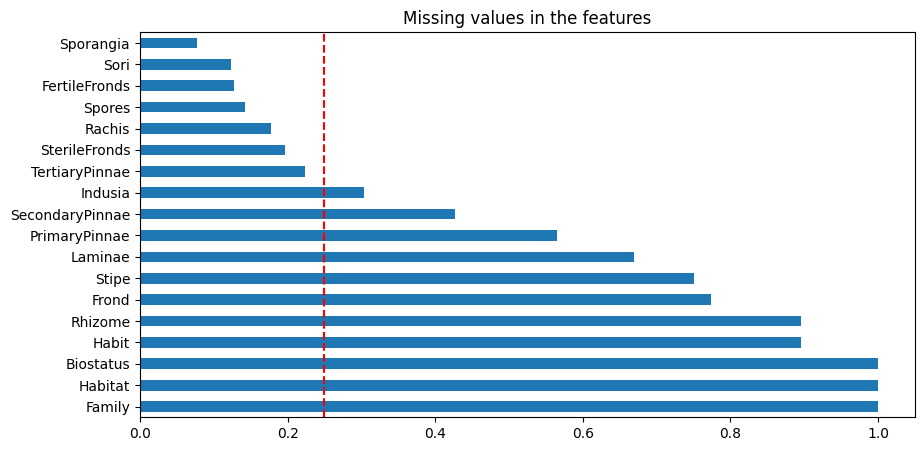

In [331]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
(features.notna().sum()/features.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')

In [86]:
filt_features = features[features.columns[features.notna().sum()/features.shape[0] > 0.25]]

In [332]:
import numpy as np
import pint
ureg = pint.UnitRegistry()

def range_to_minmax(s):
	if s.lower() in ['', 'nan']:
		return np.array([np.NaN, np.NaN])
	metric = next(re.finditer(unit, s))
	value = s[:metric.start()]
	if '-' in value:
		value = np.array(value.split('-')).astype(float)
	else:
		value = np.array([value, value]).astype(float)
	return ureg.Quantity(value, metric.group()).to('mm').magnitude


s = '115-510mm-long; 40-270mm-wide;...'
s = '115-510mm-long'
def processFeat(s:str, words=('wide', 'long')):
	if s.lower() in ['', 'nan']:
		return pd.Series()
	
	slist = s.split(';')
	m = []
	for w in words:
		firstmeasure = [x.split(f'-{w}')[0].strip() for x in slist if w in x]
		if not firstmeasure:
			# add all the measures with no word found
			firstmeasure = [x.strip() for x in slist if not any([w in x for w in words])]
		firstmeasure = firstmeasure[0] if firstmeasure else ''
		m.append(firstmeasure)

	res = {}
	for x, k in zip(m, words):
		try:
			res |= {f'{k}_{size}': v for size, v in zip(['min', 'max'], range_to_minmax(x))}
		except:
			raise ValueError(x, s, m)
			
	return pd.Series(res)

	
processFeat(s)

wide_min      NaN
wide_max      NaN
long_min    115.0
long_max    510.0
dtype: float64

In [335]:
data = pd.DataFrame()
for c in features.columns.difference(['Family', 'Habitat', 'Habit', 'Biostatus']):
    words = ['wide', 'long']
    if c in ['Frond', 'FertileFrond', 'SterileFrond']:
        words = ['long']

    data = pd.concat([data, 
                      features[c].astype(str).apply(lambda x: processFeat(x, words)).rename(columns={w: f"{c}_{w}" for w in ['wide_min', 'wide_max', 'long_min', 'long_max']})], axis=1)
data = data.join(features[['Family', 'Habitat', 'Biostatus']])


# data = data[data.columns[data.notna().sum()/data.shape[0] > 0.25]]

In [337]:
data.to_csv('processed_features_fern_NUMS.csv')

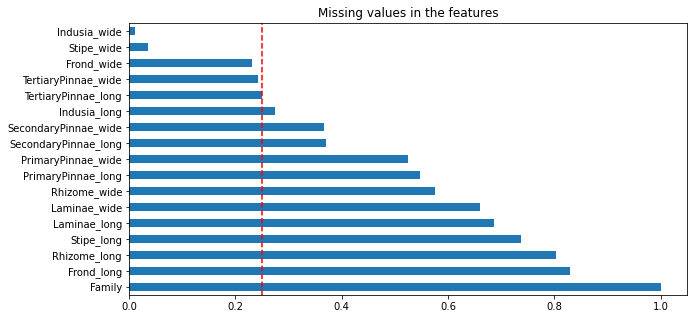

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
(data.notna().sum()/data.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')

# Felci Australia

In [3]:
fern_species = pd.read_excel("Australian fern species.xlsx")

In [70]:
from tqdm.auto import tqdm
sp_descriptions = pd.DataFrame()

text = ""
with open(f"Flora of Australia ferns.pdf", "rb") as pdf_file:
    read_pdf = PdfReader(pdf_file)
    for i, page in tqdm(enumerate(read_pdf.pages), total=len(read_pdf.pages)):
        if i < 58:
            continue
        tx = page.extract_text()
        if tx.split("\n")[0].startswith('References'):
            # print(f"Breaking at page {i}")
            break
        text += page.extract_text()
# text = re.sub(r'[^\S\r\n]+', ' ', text)

  0%|          | 0/771 [00:00<?, ?it/s]

In [92]:
def conditional_newline(sp):
    t = '\s*'.join(sp)
    return t.replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')


fern_species['start_pos'] = fern_species.Species.apply(lambda sp: re.search(conditional_newline(sp), text).start())
fern_species = fern_species.sort_values('start_pos')
fern_species['end_pos'] = fern_species.start_pos.shift(-1)
fern_species.loc[fern_species.index[-1], 'end_pos'] = re.search('INCERTAE SEDIS', text).start()
fern_species['end_pos'] = fern_species.end_pos.astype(int)
fern_species['Description'] = fern_species.apply(lambda x: text[x.start_pos:x.end_pos], axis=1)
fern_species.to_excel("fern_species_descriptions_australia.xlsx", index=False)

---

In [ ]:
sp_descriptions = pd.read_excel("fern_species_descriptions_australia.xlsx").set_index('Species')

In [95]:
extra_features_df = pd.read_excel("Australian fern species.xlsx", sheet_name="Traits")
extra_features_df = extra_features_df.drop(columns=[c for c in extra_features_df.columns if 'Unnamed' in c])
extra_features_df = extra_features_df.map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [97]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [142]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
		candidate_feat = {}
		for key, values in extra_features.items():
			if key in ('Habit', 'Venation', 'Biostatus', 'Habitat'):
				continue
			matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
			if any(matched_word):
				candidate_feat[key] = matched_word[0]
		if not any(candidate_feat):
			continue
		key = sorted(candidate_feat, key=lambda x: candidate_feat[x].start())[0]
		matched_word = candidate_feat[key]

		if key == 'Rhizome':
			features['Habit'] = list(set(features.get('Habit', []) + [x for x in extra_features['Habit'] if x in feat.lower()]))
		
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
				continue
			if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
				continue
			
			if key in ['Stipe', 'Laminae', 'Rhizome'] and len(features.get(key, [])) > 1: # TODO: da verificare per caso speciale
				hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
				# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
				if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
					continue

			features[key] = features.get(key, []) + [measure.group()]
	return pd.Series(features)


In [124]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [143]:
features = sp_descriptions.Description
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)|(; (?=sterile)|(; (?=fertile)))'
delimiter += '|' + '|'.join([f"(; (?={x.lower()}))" for x in extra_features.keys() if x not in ('Habit', 'Venation', 'Biostatus', 'Habitat')])
features = features.apply(string_preprocessing).str.split(delimiter).apply(lambda l: [x.strip() for x in l if x is not None])\
    .reset_index().apply(lambda x: extract_features(x.Species, x.Description), axis=1)

# features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
# features.index = sp_descriptions.index
# features = features[features.notna().sum(axis=1) > 0].join(sp_descriptions.Family).map(lambda x: x if x != '' else np.nan)

<Axes: title={'center': 'Missing values in the features'}>

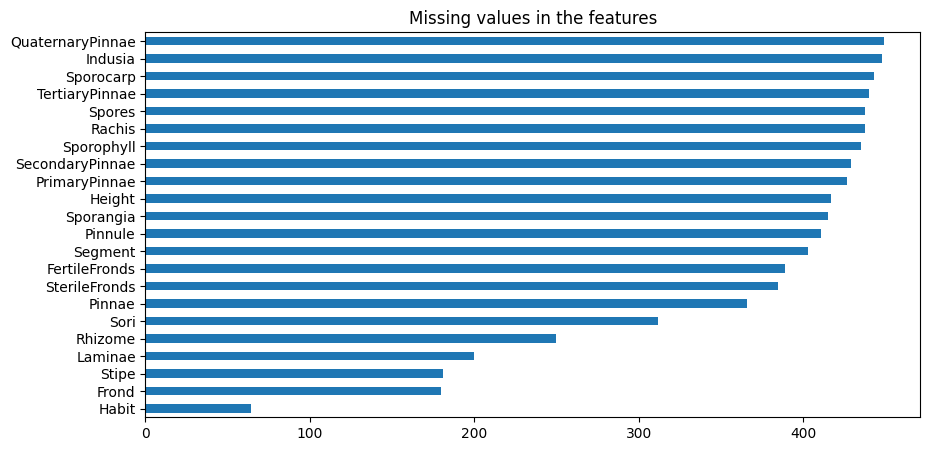

In [147]:
features.isna().sum(axis=0).sort_values().plot(kind='barh', figsize=(10, 5), title='Missing values in the features')

In [ ]:
features.Frond.value_counts()

Habit
[creeping]                            201
[]                                    164
[climbing, creeping]                    7
[aquatic]                               6
[terrestrial, creeping]                 3
[terrestrial]                           2
[climbing]                              2
[climbing, aquatic, creeping]           1
[epiphytic, terrestrial, creeping]      1
[epiphytic]                             1
[epiphytic, creeping]                   1
Name: count, dtype: int64